<a href="https://colab.research.google.com/github/YesenniaP/introducci-n-github/blob/main/Proyecto2_stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [332]:
#Se importará las librerias necesarias 
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [333]:
#se importan los datos 

df = pd.read_csv("/content/drive/MyDrive/Data Science/datos/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


El conjunto de datos a analizar es para predecir si es probable que un paciente mayor de 20 años puede sufrir un accidente cerebrovascular en función de los parámetros de entrada como el sexo, la edad, tipo de residencia, indice de masa corporal, nivel de glucosa, diversas enfermedades y el tabaquismo.

#Limpieza de datos. 

In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


En la categoria de BMI hay datos nulos, ademas tenemos 4 columnas tipo object, se revisará si hay duplicados y errores en el data. 

In [335]:
df.duplicated().sum()

0

No hay duplicados. 

Se eliminarán las columnas que no son necesarias para el objetivo del data como el id, y se hara un filtro para solo seleccionar las personas mayores de 20 años. 

In [336]:
df = df.drop(columns=["id"])
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [337]:
#Seleccionar todos los datos para solo obtener pacientes de mayores o iguales a 15 años.

age_filter = df["age"] >20
df = df.loc[age_filter, :]
df["age"].head(164)

0      67.0
1      61.0
2      80.0
3      49.0
4      79.0
       ... 
159    81.0
160    76.0
161    71.0
163    78.0
164    70.0
Name: age, Length: 164, dtype: float64

Se obtuvo el largo hasta 164 para verificar que si haya funcionado el código, ya que en el data original en la posicion 164 de la columna "age" se encontraba el primer dato menor de 20 años. 

In [338]:
#Después de la eliminar los datos menores de 20 años, miremos cuanto es el largo del data. 
df.shape

(4085, 11)

Se buscarán errores por columnas en el data. 

In [339]:
df["gender"].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [340]:
#Podemos observar que existe un dato erroneo por lo que miraremos cual es la cantidad de cada valor para poder determinar que hacer con este valor erroneo 

In [341]:
df["gender"].value_counts()

Female    2476
Male      1608
Other        1
Name: gender, dtype: int64

In [342]:
#El valor erroneo es insignificante por lo cual se decide reemplazar por el genero mas comun que es el femenino 

In [343]:
df["gender"].replace("Other","Female", inplace=True)

In [344]:
df["gender"].value_counts()

Female    2477
Male      1608
Name: gender, dtype: int64

In [345]:
#Se verificó que el error fuera corregido y efectivamente se hizo el reemplazo del dato correctamente. 

In [346]:
df["ever_married"].value_counts()

Yes    3346
No      739
Name: ever_married, dtype: int64

In [347]:
df["work_type"].value_counts()

Private          2639
Self-employed     802
Govt_job          643
Never_worked        1
Name: work_type, dtype: int64

In [348]:
#Ya quue el nunca trabajó o no trabaja es un dato insignificante, se reemplazara´ por el valor mas frecuente que el trabjar en un lugar privado. 

df["work_type"].replace("Never_worked","Private", inplace=True)


In [349]:
#verificamos

df["work_type"].value_counts()


Private          2640
Self-employed     802
Govt_job          643
Name: work_type, dtype: int64

In [350]:
df["hypertension"].value_counts()

0    3589
1     496
Name: hypertension, dtype: int64

In [351]:
df["heart_disease"].value_counts()


0    3810
1     275
Name: heart_disease, dtype: int64

In [352]:
df["Residence_type"].value_counts()


Urban    2087
Rural    1998
Name: Residence_type, dtype: int64

In [353]:
df["avg_glucose_level"].unique()



array([228.69, 202.21, 105.92, ...,  82.99, 166.29,  85.28])

In [354]:
df["bmi"].unique()


array([36.6,  nan, 32.5, 34.4, 24. , 29. , 27.4, 22.8, 24.2, 29.7, 36.8,
       27.3, 28.2, 30.9, 37.5, 25.8, 37.8, 22.4, 48.9, 26.6, 27.2, 23.5,
       28.3, 44.2, 25.4, 22.2, 30.5, 26.5, 33.7, 23.1, 32. , 29.9, 23.9,
       28.5, 26.4, 20.2, 33.6, 38.6, 39.2, 27.7, 31.4, 36.5, 33.2, 32.8,
       40.4, 25.3, 30.2, 47.5, 20.3, 30. , 28.9, 28.1, 31.1, 21.7, 27. ,
       24.1, 45.9, 44.1, 22.9, 29.1, 32.3, 41.1, 25.6, 29.8, 26.3, 26.2,
       29.4, 24.4, 28. , 28.8, 34.6, 19.4, 30.3, 41.5, 22.6, 56.6, 27.1,
       31.3, 31. , 31.7, 35.8, 28.4, 20.1, 26.7, 38.7, 34.9, 25. , 23.8,
       21.8, 27.5, 24.6, 32.9, 26.1, 31.9, 34.1, 36.9, 37.3, 45.7, 34.2,
       23.6, 22.3, 37.1, 45. , 25.5, 30.8, 37.4, 34.5, 27.9, 29.5, 46. ,
       42.5, 35.5, 26.9, 45.5, 31.5, 33. , 23.4, 30.7, 20.5, 21.5, 40. ,
       28.6, 42.2, 29.6, 35.4, 16.9, 26.8, 39.3, 32.6, 35.9, 21.2, 42.4,
       40.5, 36.7, 29.3, 19.6, 50.1, 17.7, 54.6, 35. , 22. , 39.4, 22.5,
       25.2, 41.8, 60.9, 23.7, 24.5, 31.2, 25.1, 24

In [355]:
df["smoking_status"].value_counts()


never smoked       1672
formerly smoked     854
Unknown             799
smokes              760
Name: smoking_status, dtype: int64

En esta columna vemos que existe una variable llamada "Unknown" lo cual no me arrojaría valor para el data y se trata como valores nulos, por lo cual se decide reemplazar la variable con never smoked que es lo mas frecuente en esta columna. 

In [356]:
df["smoking_status"].replace({"Unknown": "never smoked"},inplace=True)
df["smoking_status"].value_counts()

never smoked       2471
formerly smoked     854
smokes              760
Name: smoking_status, dtype: int64

In [357]:
df["stroke"].value_counts()


0    3838
1     247
Name: stroke, dtype: int64

In [358]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  176
smoking_status         0
stroke                 0
dtype: int64

Como se habia mencionado anteriormente en la columna bmi hay datos nulos, representando aproximadamente el 0.045% de los datos, por lo que se decide elimninar las filas de los datos nulos. 


In [359]:
df.dropna(subset=["bmi"], inplace=True) 


In [360]:
#Verificamos
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Se van a visualizar los datos para mirar su comportamiento por medio de gráficos y mapa de color para correlaciones. 

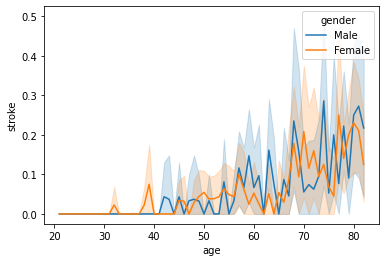

In [361]:
sns.lineplot(data=df, x="age", y="stroke", hue ="gender", palette="tab10")

Podemos observar como entre mas edad y ser hombre tiene más riesgo de accidente cerebrovascular. 

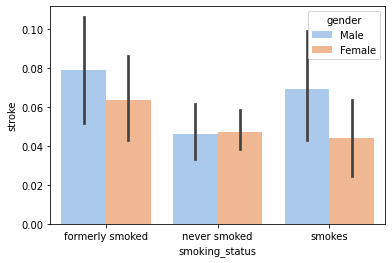

In [362]:
sns.barplot(data=df, x="smoking_status", y="stroke", hue="gender", palette="pastel")

Podemos observar que el haber fumado es un argumento fuerte para presentar un accidente de riesgo cardiovascular, seguido de ser un fumador activo. 

Ahora bien, en general, las personas en la zona urbana fue donde mas se presnetó el stroke. 

Text(0.5, 0, 'Estado civil')

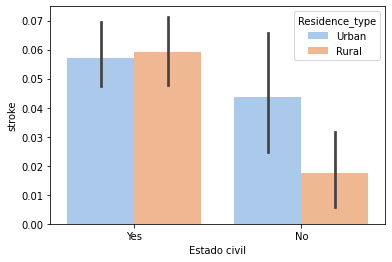

In [465]:
sns.barplot(data=df, x="ever_married", y="stroke", hue="Residence_type", palette="pastel")
plt.xlabel("Estado civil")

In [364]:
#Hacer gráfico que muestre quien tiene mas tiesgo de stroke 
#es decir hallar el promedio de niveles de glucos de IMC y quien tiene hipertension con esos resultadps compararlo
#con las personas que estan menor a esos valores 

Ahora graficaremos las diferentes comobilidades para ver su comportamiento frente a un evento isquemico cerebral 

In [415]:
comorbilidades = df[(df['hypertension'] ==1) & (df['heart_disease'] ==1) & (df["avg_glucose_level"] >=126) & (df["bmi"] >=30)]
comorbilidades

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
115,Male,71.0,1,1,No,Govt_job,Rural,216.94,30.9,never smoked,1
193,Male,68.0,1,1,Yes,Private,Rural,271.74,31.1,smokes,1
201,Male,80.0,1,1,Yes,Private,Urban,175.29,31.5,formerly smoked,1
217,Female,55.0,1,1,Yes,Private,Urban,210.40,40.0,smokes,1
243,Female,68.0,1,1,Yes,Private,Urban,247.51,40.5,formerly smoked,1
350,Female,79.0,1,1,Yes,Self-employed,Urban,200.28,30.0,formerly smoked,0
990,Male,61.0,1,1,No,Private,Rural,148.24,32.2,formerly smoked,0
1067,Male,67.0,1,1,Yes,Private,Rural,254.63,31.0,never smoked,0
1189,Male,73.0,1,1,Yes,Self-employed,Rural,230.68,37.7,never smoked,0
1283,Male,63.0,1,1,Yes,Private,Urban,150.45,44.5,formerly smoked,0


In [417]:
no_comorbilidades = df[(df['hypertension'] ==0) & (df['heart_disease'] ==0) & (df["avg_glucose_level"] <126) & (df["bmi"] <30)]
no_comorbilidades

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,never smoked,1
12,Female,54.0,0,0,Yes,Private,Urban,104.51,27.3,smokes,1
24,Male,71.0,0,0,Yes,Private,Urban,102.87,27.2,formerly smoked,1
25,Male,80.0,0,0,Yes,Self-employed,Rural,104.12,23.5,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5090,Male,26.0,0,0,No,Govt_job,Rural,100.85,21.0,smokes,0
5096,Male,57.0,0,0,Yes,Govt_job,Rural,76.62,28.2,never smoked,0
5101,Female,45.0,0,0,Yes,Private,Urban,97.95,24.5,never smoked,0
5102,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0


Text(0.5, 1.0, 'Personas con comorbilidades que tuvieron un accidente cerebroscular isquémico\n\n')

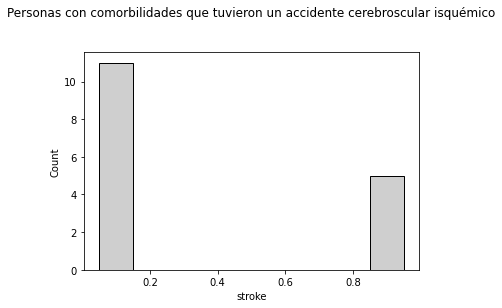

In [464]:
sns.histplot(data=comorbilidades, x="stroke", multiple="dodge", shrink=.5, color= "silver")
plt.title("Personas con comorbilidades que tuvieron un accidente cerebroscular isquémico""\n""\n")



Text(0.5, 1.0, 'Personas sin comorbilidades que tuvieron un accidente cerebroscular isquémico\n\n')

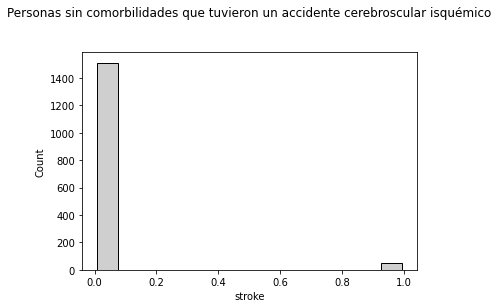

In [467]:
sns.histplot(data=no_comorbilidades, x="stroke", multiple="dodge", shrink=.8, color= "silver")
plt.title("Personas sin comorbilidades que tuvieron un accidente cerebroscular isquémico""\n""\n")

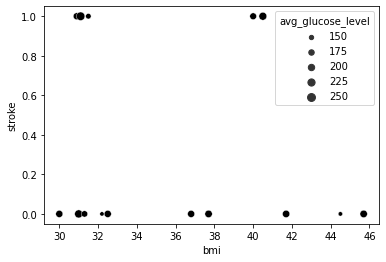

In [456]:
sns.scatterplot(data=comorbilidades, x="bmi", y="stroke", size="avg_glucose_level", color = "black")

(array([140., 160., 180., 200., 220., 240., 260., 280.]),
 <a list of 8 Text major ticklabel objects>)

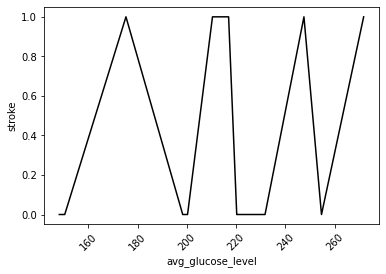

In [455]:
sns.lineplot(data=comorbilidades, x="avg_glucose_level", y="stroke", color="black")
plt.xticks(rotation=45)

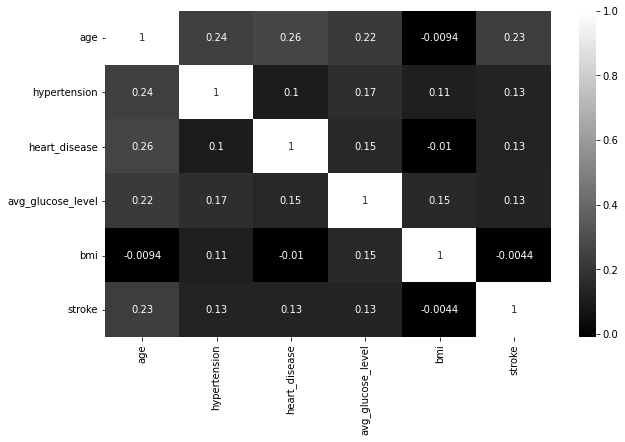

In [366]:
corr = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap = "gray", annot=True)
plt.show()

Las columnas con mejor correlación con la columna objetivo son el nivel de glucosa, enfermedades de corazón hipertención y la edad siendo esta última con mas correlación. 
Por lo que podemos concluir que las variables por si solas no representan correlacion significativa con el objetivo. 

##Preprocesamiento

In [367]:
X = df.drop("stroke", axis=1)
y = df["stroke"]


In [368]:
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")

In [369]:
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [370]:
# Tuples para Column Transformer
number_tuple = (scaler, num_selector)
category_tuple = (ohe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fac9d315400>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fac97b3a6d0>)])

In [371]:
# fit on train
preprocessor.fit(X)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fac9d315400>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fac97b3a6d0>)])

In [372]:
X= preprocessor.transform(X)

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,stratify=y)

#Modelos

Utilizaremos modelos de clasificación para mirar que modelo es mejor para este conjunto de datos. 

In [390]:
#arbol de decisiones
dec_tree = DecisionTreeClassifier(random_state = 42)

#KNN
knn = KNeighborsClassifier()

#regresionlogistica
logreg = LogisticRegression()

In [391]:
dec_tree.fit(X_train, y_train)
knn.fit(X_train, y_train)
logreg.fit(X_train,y_train)

LogisticRegression()

In [392]:
dec_tree_pred = dec_tree.predict(X_test)
knn_pred = knn.predict(X_test)
log_pred = logreg.predict(X_test)



Evaluaremos los modelos 

In [393]:
# calculen la exactitud de la clasificación
score_train_1 = dec_tree.score(X_train, y_train)
score_train_2 = knn.score(X_train, y_train)
score_train_3 = logreg.score(X_train, y_train)

score_test_1 = dec_tree.score(X_test, y_test)
score_test_2 = knn.score(X_test, y_test)
score_test_3 = logreg.score(X_test, y_test)

print(f"Exactitud del arbol de decisiones en el conjunto de prueba",score_test_1)
print(f"Exactitud de knn en el conjunto de prueba                 ",score_test_2)
print(f"Exactitud de regresion logistica en el conjunto de prueba ",score_test_3,"\n") 


print(f"Exactitud del arbol de decisiones en el conjunto de entrenamiento",score_train_1)
print(f"Exactitud de knn en el conjunto de entrenamiento                 ",score_train_2)
print(f"Exactitud del regresión logistica en el conjunto de entrenamiento",score_train_3)


Exactitud del arbol de decisiones en el conjunto de prueba 0.8926380368098159
Exactitud de knn en el conjunto de prueba                  0.9447852760736196
Exactitud de regresion logistica en el conjunto de prueba  0.9468302658486708 

Exactitud del arbol de decisiones en el conjunto de entrenamiento 1.0
Exactitud de knn en el conjunto de entrenamiento                  0.9474582053906516
Exactitud del regresión logistica en el conjunto de entrenamiento 0.946775844421699


In [394]:
print(f'Training AUC: {roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])}')


Training AUC: 0.817847077847078
Testing AUC: 0.8007974746635654


In [395]:
print(f'Training AUC: {roc_auc_score(y_train, knn.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])}')

Training AUC: 0.9334615384615385
Testing AUC: 0.6073267984715068


In [396]:
print(f'Training AUC: {roc_auc_score(y_train, dec_tree.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, dec_tree.predict_proba(X_test)[:,1])}')

Training AUC: 1.0
Testing AUC: 0.5349102841003488


In [397]:
y_true = list(y_test)
print(classification_report(y_true,dec_tree.predict(X_test), labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.10      0.13      0.12        52
           0       0.95      0.94      0.94       926

    accuracy                           0.89       978
   macro avg       0.53      0.53      0.53       978
weighted avg       0.91      0.89      0.90       978



In [398]:
y_true = list(y_test)
print(classification_report(y_true,knn.predict(X_test), labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        52
           0       0.95      1.00      0.97       926

    accuracy                           0.94       978
   macro avg       0.47      0.50      0.49       978
weighted avg       0.90      0.94      0.92       978



In [400]:
y_true = list(y_test)
print(classification_report(y_true, logreg.predict(X_test), labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        52
           0       0.95      1.00      0.97       926

    accuracy                           0.95       978
   macro avg       0.47      0.50      0.49       978
weighted avg       0.90      0.95      0.92       978



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


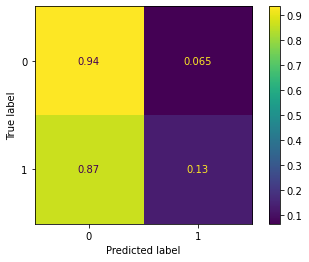

In [401]:
ConfusionMatrixDisplay.from_predictions(y_true, dec_tree.predict(X_test), normalize="true")

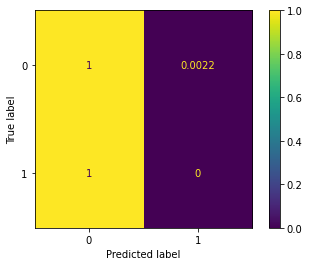

In [402]:
ConfusionMatrixDisplay.from_predictions(y_true, knn.predict(X_test), normalize="true")

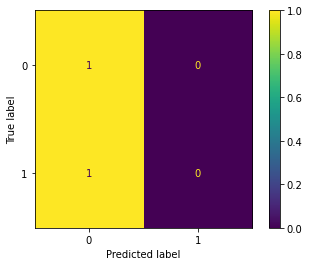

In [403]:
ConfusionMatrixDisplay.from_predictions(y_true, logreg.predict(X_test), normalize="true")

Al evaluar los modelos podemos ver que en general solo son utiles para predecir que personas no tienen riesgo de sufrir un accidente cerebrovascular isquémico 
El modelo mas indicado seria regresion logistica dado que es el modelo que mejor se comporta con los datos de prueba en las mayoria de las metricas de evaluación de modelos



#conclusiones

1. Entre mas comorbilidades presente el paciente mas riesgo tiene de tener un accidente cerebrovascular isquémico

2. Las características individuales no representan riesgo significativo en presentar accidente cerebrovascular isquémico

3. Los modelo de predicción solo son útiles para predecir los pacientes que no van a sufrir de un accidente cerebrovascular isquémico